In [60]:
import pandas as pd
import nltk
from nltk import word_tokenize, ngrams
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
import math

HOME_DIR = "/home_remote"

In [61]:
import os

positives_df_path = os.path.join(HOME_DIR, "positive_df.pkl")
negatives_df_path = os.path.join(HOME_DIR, "negative_df.pkl")

In [62]:
negatives = pd.read_pickle(negatives_df_path).reset_index(drop=True)

negatives

,Title,Date,Text,Info,TrainSubjectId
0,Is receive all still broken?,2015-05-02 03:13:53,My boyfriends receive all works(on iOS) but m...,reddit post,train_subject3533
1,,2015-04-29 17:13:41,It's about a 30 mile commute mostly on free w...,reddit post,train_subject3533
2,,2015-04-29 05:51:29,"I wanna spend less than 10k, and I'd use it a...",reddit post,train_subject3533
3,,2015-04-29 01:20:07,Thank you for the advice. I was planning on b...,reddit post,train_subject3533
4,"First time Craigslist buyer, need some advice!",2015-04-28 22:21:09,I'm trying to buy a car and I'm looking at ad...,reddit post,train_subject3533
...,...,...,...,...,...
266075,,2014-02-20 22:07:35,Ice fishing?,reddit post,train_subject3418
266076,,2014-02-20 22:03:08,God. Fucking. Dammit.,reddit post,train_subject3418
266077,,2014-02-19 02:49:52,That smile...,reddit post,train_subject3418
266078,,2014-02-15 18:19:35,Yowza! Look at the gams on that bird!,reddit post,train_subject3418


In [63]:
positives = pd.read_pickle(positives_df_path).reset_index(drop=True)

positives

,Title,Date,Text,Info,TrainSubjectId
0,,2015-06-13 22:06:19,"I'm pretty sure the definition is ""It's not s...",reddit post,train_subject96
1,,2015-02-23 05:35:18,Thank you very much.,reddit post,train_subject405
2,,2015-02-23 05:00:31,Haha.,reddit post,train_subject405
3,2003 Crown Vic,2015-02-23 00:32:01,2FAFP71W23X220401,reddit post,train_subject405
4,,2015-01-30 04:22:56,I already got my refund! it was approved than...,reddit post,train_subject405
...,...,...,...,...,...
30950,,2015-07-18 23:27:05,Why thank you and greatly appreciate the info...,reddit post,train_subject8741
30951,,2014-11-14 19:09:23,Horrible caption.,reddit post,train_subject7042
30952,,2014-11-06 03:45:20,That's actually terrifying,reddit post,train_subject7042
30953,,2014-11-06 01:06:07,Where can you purchase these?,reddit post,train_subject7042


In [64]:
def entropy(list):
    freqdist = nltk.FreqDist(list)
    probs = [freqdist.freq(l) for l in freqdist]
    return -sum(p * math.log(p,2) for p in probs)

In [65]:
def tokenize(text):
  """
  Parameters:
    text (list): A list of text

  Returns:
    A tuple of unigrams and bigrams
  """
  corpus = ' '.join(text)
  tokens = word_tokenize(corpus)
  unigrams = [word for word in tokens if word.isalpha()]
  bigrams = ngrams(unigrams, 2)

  return {"unigrams": unigrams, "bigrams": list(bigrams)}

# Calculate IG based on formula

In [23]:
def count_of_documents(term, class_documents, is_check_contain_term):
  """
  Count of documents that contains/not contains term t and are not in classC

  Parameters:
    term (str) The term
    class_documents (pandas.Series) Series of documents used for checking contain term or not
    is_check_contain_term (bool) Flag indicates that count document contains term. (False = 0 = not contain; True = 1 = contain)
  """

  """
  loop all documents

  if is_check_in_class == True:
    # check documents in negative
    if is_check_contain_term == True:
      # document must contain term
    else:
      # document must not contain term
  else:
    # check documents must not in negative, in other words check documents in positive
    if is_check_contain_term == True:
      # document must contain term
     else:
      # document must not contain term
  """

  result = 0

  for doc in class_documents:
    if (is_check_contain_term == True) and (term in doc):
      result += 1
    elif (is_check_contain_term == False) and (term not in doc):
      result += 1

  return result


In [24]:
def information_gain_against_positive_class(term, negative_documents, positive_documents):
  """
  Based on equation 13.17 (p.272) in An Introduction to Information Retrieval
  """

  all_documents = pd.concat([negative_documents, positive_documents])

  # number of documents contain term t and in class negative
  n_1_1 = count_of_documents(term, positive_documents, is_check_contain_term=True)

  # number of documents don't contain term t and in class negative
  n_0_1 = count_of_documents(term, positive_documents, is_check_contain_term=False)

  # number of documents contain term t and not in class negative (in class positive)
  n_1_0 = count_of_documents(term, negative_documents, is_check_contain_term=True)

  # number of documents don't contain term t and not in class negative (in class positive)
  n_0_0 = count_of_documents(term, negative_documents, is_check_contain_term=False)

  n_1_all = n_1_0 + n_1_1

  n_0_all = n_0_0 + n_0_1

  n_all_1 = n_0_1 + n_1_1

  n_all_0 = n_0_0 + n_1_0

  # total number of documents
  n = n_1_1 + n_1_0 + n_0_1 + n_0_0 # should equal len(all_documents)
  # print(f"Total number of documents {n}")
  # print(f"Total number of documents (from input) {len(all_documents)}")

  try:
    return (
        n_1_1 / n * math.log2(n * n_1_1 / (n_1_all * n_all_1)) +
        n_0_1 / n * math.log2(n * n_0_1 / (n_0_all * n_all_1)) +
        n_1_0 / n * math.log2(n * n_1_0 / (n_1_all * n_all_0)) +
        n_0_0 / n * math.log2(n * n_0_0 / (n_0_all * n_all_0))
    )
  except:
    # Note: there are cases that denominator can be 0, so assume IG = 0
    return 0

In [27]:
positive_tokens = tokenize(positives['Text'])
negative_tokens = tokenize(negatives['Text'])
negative_unigrams = pd.Series(negative_tokens['unigrams'])
positive_unigrams = pd.Series(positive_tokens['unigrams'])

In [28]:
most_frequent_negative_unigrams = negative_unigrams.value_counts().head(100).index
positive_unigrams_without_most_frequent_negative_unigrams = positive_unigrams[~positive_unigrams.isin(most_frequent_negative_unigrams)]
positive_unigrams_without_most_frequent_negative_unigrams.drop_duplicates(inplace=True)
positive_unigrams_without_most_frequent_negative_unigrams

1               pretty
2                 sure
4           definition
8              slander
11                true
              ...     
1143791      topically
1144296      coincided
1144472    simplifying
1144732          amber
1144826           nami
Length: 39446, dtype: object

In [14]:
information_gain_of_positive_unigrams_df = pd.DataFrame(positive_unigrams_without_most_frequent_negative_unigrams, columns=['Token'])

In [15]:
information_gain_of_positive_unigrams_df['IG'] = information_gain_of_positive_unigrams_df['Token'].apply(information_gain_against_positive_class, args=(negatives['Text'], positives['Text']))

In [30]:
ig_of_pos_unigrams_path = "/content/drive/MyDrive/Master_Thesis/ig_of_pos_unigrams.pkl"

In [16]:
information_gain_of_positive_unigrams_df.to_pickle(ig_of_pos_unigrams_path)

In [17]:
information_gain_of_positive_unigrams_df

,Token,IG
1,pretty,8.044553e-04
2,sure,5.949010e-04
4,definition,5.148225e-06
8,slander,3.074976e-07
11,true,1.145934e-05
...,...,...
1143791,topically,0.000000e+00
1144296,coincided,9.690626e-07
1144472,simplifying,1.092987e-08
1144732,amber,3.839130e-06


# Calculate IG using library

In [66]:
positive_tokens = tokenize(positives['Text'])
negative_tokens = tokenize(negatives['Text'])
negative_unigrams = negative_tokens['unigrams']
positive_unigrams = positive_tokens['unigrams']
all_unigrams = positive_unigrams + negative_unigrams

In [67]:
word_freqdist = FreqDist()
labeled_word_freqdist = ConditionalFreqDist()

for word in positive_unigrams:
  word_freqdist[word.lower()] += 1
  labeled_word_freqdist['positive'][word.lower()] += 1

for word in negative_unigrams:
  word_freqdist[word.lower()] += 1
  labeled_word_freqdist['negative'][word.lower()] += 1

In [68]:
pos_word_count = labeled_word_freqdist['positive'].N()
neg_word_count = labeled_word_freqdist['negative'].N()
total_word_count = pos_word_count + neg_word_count

word_scores = {}

most_common_negative_words = [element for element, frequency in labeled_word_freqdist['negative'].most_common(21)]

for word in word_freqdist:
  # skip most common words in negative category
  if word in most_common_negative_words:
    continue
  freq = word_freqdist.freq(word)
  pos_score = BigramAssocMeasures.chi_sq(labeled_word_freqdist['positive'][word], (freq, pos_word_count), total_word_count)
  word_scores[word] = pos_score

In [69]:
word_scores

{'do': 98576978772.69315,
 'my': 192721708768.24387,
 'they': 42196550450.512924,
 'as': 47599714577.85166,
 'if': 64463570837.75324,
 'or': 47555962624.124466,
 'so': 78757537662.30573,
 'just': 66987025394.93727,
 'like': 63435138408.79254,
 'he': 52573939636.86576,
 'at': 48348232655.34134,
 'what': 41731003604.105515,
 'would': 42929924286.54214,
 'me': 110556514373.39244,
 'your': 37110538617.34785,
 'all': 35790528860.88682,
 'from': 26595391539.935917,
 'about': 42930330276.672905,
 'can': 42425587318.57736,
 'there': 28983804829.58104,
 'we': 26893247180.4724,
 'an': 22839337724.531933,
 'one': 34658637982.19423,
 'http': 3798460401.287821,
 'out': 39629186361.20144,
 'people': 39162582170.43147,
 'get': 42169190658.90924,
 'up': 36696283397.06237,
 'more': 22864318493.22523,
 'no': 24294623564.38881,
 'when': 40402074669.84866,
 'will': 19618157767.487923,
 'by': 12099040674.142374,
 'has': 16725007300.17238,
 'some': 24545393955.851284,
 'how': 29723589957.156788,
 'them': 25

# Draw word cloud

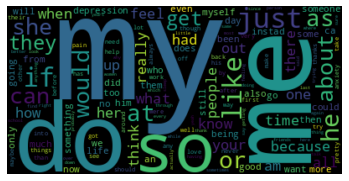

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_scores)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()